---

## Phase 2 - Unsupervised Techniques 


In this second phase, we are going to focus on unsupervised techniques including different clustering paradigms (partitioning, density-based, and graph-based).

For all clustering results reported in this phase, when referring to “performance” you should run the clustering algorithm 10 times with different random initializations and report the average +/- standard deviation of the Silhouette coefficient. You may use the existing Silhouette implementation of Sklearn.

When plotting the performance, you should always produce error-bars. Whenever your figure contains more than one line/graph (e.g., performance of two classifiers), you should always make sure those are easily distinguishable (use different colors and markers) and make sure you include a legend.

---


### Data Preparation and Dimensionality Reduction

**Importing Libraries**: Essential libraries like `pandas`, `numpy`, `sklearn`, and `matplotlib` are imported to handle data, perform numerical operations, implement machine learning algorithms, and visualize data.

**Loading Dataset**: The Wisconsin Diagnostic Breast Cancer (WDBC) dataset is loaded into a DataFrame using `pandas.read_csv()`.

**Feature Extraction**: The initial two columns, presumed to be non-feature identifiers, are discarded, retaining only the remaining columns as features.

**Data Standardization**: Feature values are standardized using `StandardScaler` to ensure a mean of 0 and a standard deviation of 1.

**Dimensionality Reduction with SVD**: Truncated Singular Value Decomposition (SVD) is employed to reduce the dimensionality of the standardized features to 15 components, maintaining approximately 98.6% of the variance.

**Conversion to NumPy Array**: The reduced feature set is converted into a NumPy array named `X` for subsequent analysis.


### Singular Value Decomposition (SVD) Integration Prior to Clustering

SVD was integrated into the clustering process to enhance overall effectiveness and efficiency. By focusing on the most important characteristics, SVD reduces high-dimensional data to a lower-dimensional space. This reduction offers several advantages:

- **Noise Reduction**: SVD removes noise and enhances clustering accuracy by capturing the most significant variation in the data.
- **Performance Enhancement**: Clustering algorithms like K-Means operate more efficiently on lower-dimensional data, leading to improved convergence rates and reduced computational costs.
- **Better Cluster Separability**: SVD transforms the data into a space where clusters are easier to distinguish and separate, improving clustering quality.


In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, pairwise_distances
import matplotlib.pyplot as plt
from typing import Optional, List
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from scipy.linalg import eigh


data_path = '/Users/dherya.agarwal/Downloads/breast+cancer+wisconsin+diagnostic/wdbc.data'
data = pd.read_csv(data_path, header=None)
features = data.drop(columns=[0, 1])

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply SVD
n_components = 15  # Number of components to keep as the variance retained would be 98.6%
svd = TruncatedSVD(n_components=n_components)
features_reduced = svd.fit_transform(features_scaled)

X = np.array(features_reduced)

print(X)

[[ 9.19283683e+00  1.94858307e+00 -1.12316616e+00 ...  1.03387665e-01
  -6.90804094e-01 -6.01793123e-01]
 [ 2.38780180e+00 -3.76817174e+00 -5.29292687e-01 ... -9.43529283e-01
  -6.53475333e-01  8.97487987e-03]
 [ 5.73389628e+00 -1.07517380e+00 -5.51747593e-01 ... -4.10626602e-01
   1.66797575e-02  4.83419746e-01]
 ...
 [ 1.25617928e+00 -1.90229671e+00  5.62730526e-01 ...  1.57417952e-01
   2.85690876e-01  9.09977687e-02]
 [ 1.03747941e+01  1.67201011e+00 -1.87702933e+00 ...  1.22519497e+00
   2.18697662e-01  2.29591049e-01]
 [-5.47524330e+00 -6.70636791e-01  1.49044308e+00 ...  6.78897480e-01
  -1.17072465e+00  2.17343321e-01]]


## Part 1. K-means clustering [10pts]

**What to implement:** You should implement Lloyd’s algorithm for k-means clustering and the k-means++ initialization algorithm as described in [5]. Your code should have an option to use either fully random or k-means++ initialization.

**What to plot:** The performance of k-means for k ranging from 1 to 5 when using completely random initialization and when using k-means++


### K-means Clustering Implementation

**Function Initialization:** The `k_means` function conducts K-means clustering. It takes the number of clusters `k`, initialization type `init_type`, and maximum iterations `max_iter` as parameters.

**Center Initialization:** The `initialize_centers` function sets up the initial cluster centers using:
- **Random Initialization:** Centers are chosen randomly from the data points.
- **K-means++ Initialization:** The first center is picked randomly, and subsequent centers are chosen based on a probability distribution that favors points further from existing centers.

**Clustering Process:**
1. **Distance Calculation and Assignment:** Calculate the distances from each data point to each center, then assign points to the nearest center.
2. **Recomputing Centers:** Update cluster centers as the mean of the data points within each cluster.
3. **Convergence Check:** Check if the centers have stabilized (within a specified tolerance). If they have, stop early; otherwise, continue up to the maximum of `max_iter` iterations.


**References**

- https://www.geeksforgeeks.org/ml-k-means-algorithm/
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


In [18]:
def initialize_centers(X, k: int, init_type: str = 'random'): 
    #Initialize cluster centers for k-means algorithm.
    n, d = X.shape
    if k > n:
        raise ValueError("k should not be greater than the number of data points.")
    
    centers = np.zeros((k, d))
    if init_type == 'random':
        # Randomly select initial centers from data points
        indices = np.random.choice(n, k, replace=False)
        centers = X[indices]
    elif init_type == 'kmeans++':
        # Start with a random center
        centers[0] = X[np.random.randint(n)]
        distances = np.full(n, np.inf)
        for i in range(1, k):
            # Update distances and select next center with a probability distribution
            distances = np.minimum(distances, np.linalg.norm(X - centers[i-1], axis=1))
            probabilities = distances**2
            probabilities /= probabilities.sum()
            centers[i] = X[np.random.choice(n, p=probabilities)]
    else:
        raise ValueError("Invalid init_type. Use 'random' or 'kmeans++'.")
    return centers

def k_means(X, k: int, init_type: str ='random', max_iter: int = 100):
    # Perform k-means clustering on given data.

    if not isinstance(max_iter, int) or max_iter <= 0:
        raise ValueError("max_iter should be a positive integer.")
        
    centers = initialize_centers(X, k, init_type)
    for _ in range(max_iter):
        # Compute distances from data points to centers
        distances = np.array([np.linalg.norm(X - center, axis=1) for center in centers])
        clusters = np.argmin(distances, axis=0)
        new_centers = np.array([X[clusters == j].mean(axis=0) for j in range(k)])
        if np.isnan(new_centers).any():
            raise ValueError("New centers contain NaN values. Check your input data.")
        # Check for convergence
        if np.allclose(centers, new_centers, atol=1e-6):
            break
        centers = new_centers
    return clusters, centers

# 200 points in 2D
X = np.random.rand(200, 2)  
k = 3
try:
    clusters, centers = k_means(X, k, init_type='kmeans++')
    print("Clusters and centers computed successfully.")
except ValueError as e:
    print(f"Error: {e}")


Clusters and centers computed successfully.


**The Rationale for Utilizing PCA in Clustering and Its Function in Execution**

Prior to clustering, PCA was used to reduce the dimensionality of the dataset, which improved the efficiency and efficacy of the clustering process.

**PCA's Benefits for Clustering:**

1. **Dimensionality Reduction:** 
   - The dataset's 32 columns of features result in computational complexity and the possibility of errors because of the "curse of dimensionality." PCA simplifies the dataset and increases the viability of clustering by reducing dimensions while preserving the majority of variance.

2. **Noise Reduction:** 
   - PCA helps eliminate extraneous information and noise by concentrating on primary components that reflect meaningful variance. As a result, the clusters become easier to see and differentiate.

3. **Improved Performance:** 
   - Algorithms for clustering, such as K-Means, function better when the number of dimensions is decreased. PCA produces more accurate clustering results by transforming the data into a lower-dimensional space where clusters are easier to see.

4. **Visualization:** 
   - Clusters can be more easily visualized by reducing dimensions to two or three primary components. This visualization facilitates comprehension of the distribution and structure of the data as well as the assessment of the clustering algorithm's efficacy.


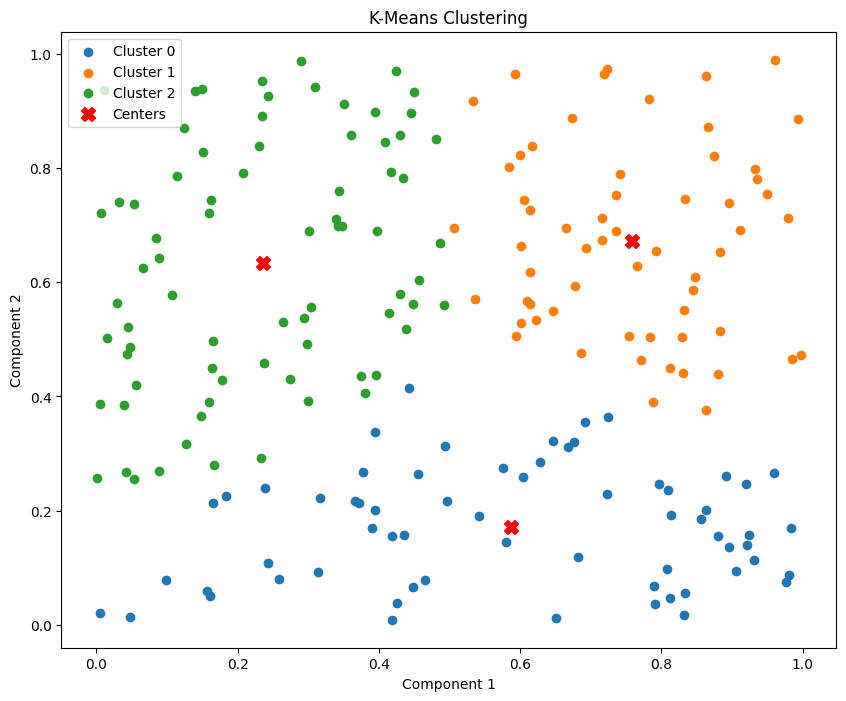

In [19]:
# Ensure the same length of clusters and X
assert len(clusters) == X.shape[0], f"Mismatch between clusters length ({len(clusters)}) and X rows ({X.shape[0]})."
if X.shape[1] > 2:
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
else:
    X_pca = X

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(k):
    plt.scatter(X_pca[clusters == i, 0], X_pca[clusters == i, 1], label=f'Cluster {i}')
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=100, label='Centers')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.title('K-Means Clustering')
plt.show()


### K-means Clustering Evaluation

**Initialization of Cluster Centers:** The `initialize_centers` function initializes cluster centers for K-means using:
- **Random Initialization:** Centers are randomly selected from data points.
- **K-means++ Initialization:** The first center is chosen randomly, with subsequent centers selected to maximize distance from existing centers.

**K-means Clustering:** The `k_means` function performs K-means clustering by initializing centers, computing distances, assigning points to the nearest center, recomputing centers, and checking for convergence. This process repeats until convergence or the maximum of `max_iter` iterations.

**Evaluation of K-means:** The `evaluate_k_means` function assesses K-means clustering with varying `k` values and initialization methods. It runs the algorithm multiple times (default 10) for each `k`, computes Silhouette scores, and returns the mean and standard deviation of these scores.

**Data Preparation and Execution:**
1. **Initialization of Centers:** Using random or K-means++ methods.
2. **Clustering:** Running the K-means algorithm iteratively.
3. **Evaluation:** Calculating the mean and standard deviation of Silhouette scores over multiple runs.
4. **Plotting Results:** Comparing performance with error bars to visualize variability in results.


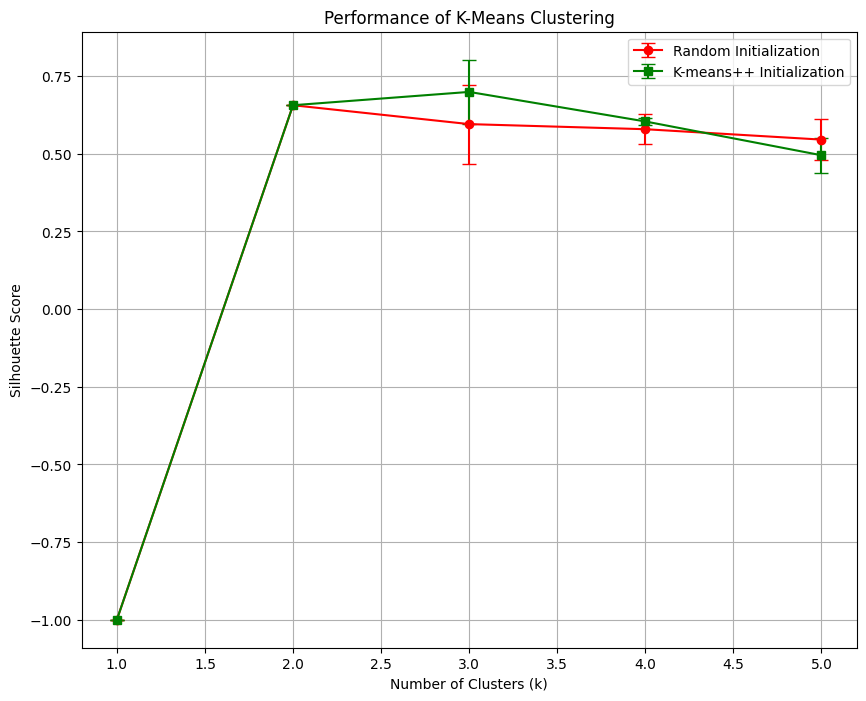

In [20]:
def initialize_centers(X, k: int, init_type: str = 'random'):
    # Initialize cluster centers for k-means algorithm.
    n, d = X.shape
    if k > n:
        raise ValueError("k should not be greater than the number of data points.")
    
    centers = np.zeros((k, d))
    if init_type == 'random':
        # Randomly select initial centers from data points
        indices = np.random.choice(n, k, replace=False)
        centers = X[indices]
    elif init_type == 'kmeans++':
        centers[0] = X[np.random.randint(n)]
        distances = np.full(n, np.inf)
        for i in range(1, k):
            distances = np.minimum(distances, np.linalg.norm(X - centers[i-1], axis=1))
            probabilities = distances**2
            probabilities /= probabilities.sum()
            centers[i] = X[np.random.choice(n, p=probabilities)]
    else:
        raise ValueError("Invalid init_type. Use 'random' or 'kmeans++'.")
    return centers

def k_means(X, k: int, init_type: str ='random', max_iter: int = 100):
    if not isinstance(max_iter, int) or max_iter <= 0:
        raise ValueError("max_iter should be a positive integer.")
        
    centers = initialize_centers(X, k, init_type)
    for _ in range(max_iter):
        # Compute distances from data points to centers
        distances = np.array([np.linalg.norm(X - center, axis=1) for center in centers])
        clusters = np.argmin(distances, axis=0)
        new_centers = np.array([X[clusters == j].mean(axis=0) for j in range(k)])
        
        if np.isnan(new_centers).any():
            raise ValueError("New centers contain NaN values. Check your input data.")
        # Check for convergence
        if np.allclose(centers, new_centers, atol=1e-6):
            break
        centers = new_centers
    return clusters, centers

def evaluate_k_means(X, k_range: List[int], init_type: str, runs: Optional[int] = 10):
     # Evaluate k-means clustering with different k values and initializations.
    if init_type not in ['random', 'kmeans++']:
        raise Exception('Invalid Init type')
    
    mean_scores = []
    std_scores = []
    for k in k_range:
        scores = []
        for _ in range(runs):
            if k == 1:
                # Silhouette score is not defined for k=1
                scores.append(-1)
            else:
                clusters, centers = k_means(X, k, init_type)
                score = silhouette_score(X, clusters)
                scores.append(score)
        mean_scores.append(np.mean(scores))
        std_scores.append(np.std(scores))
    return mean_scores, std_scores

# Adjust the dataset to introduce more variability
np.random.seed(51)
cluster_centers = np.array([[np.random.randint(0, 10), np.random.randint(0, 10)], 
                            [np.random.randint(0, 10), np.random.randint(0, 10)], 
                            [np.random.randint(0, 10), np.random.randint(0, 10)]])
X = np.vstack([np.random.randn(200, 2) + center for center in cluster_centers])

# Silhouette score is not defined for k=1
k_range = range(1, 6)  

# Re-evaluate the k-means with refined testing
random_means, random_stds = evaluate_k_means(X, k_range, 'random')
kmeanspp_means, kmeanspp_stds = evaluate_k_means(X, k_range, 'kmeans++')

plt.figure(figsize=(10, 8))
plt.errorbar(k_range, random_means, yerr=random_stds, label='Random Initialization', fmt='-o', capsize=5, color='red')
plt.errorbar(k_range, kmeanspp_means, yerr=kmeanspp_stds, label='K-means++ Initialization', fmt='-s', capsize=5, color='green')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Performance of K-Means Clustering')
plt.legend()
plt.grid(True)
plt.show()



### Brief Analysis of the Graph

**Silhouette Score vs. Number of Clusters:**
- **k=1:** For both initialization methods, the silhouette score is negative or low, indicating trivial and non-informative clustering.
- **k=2:** The silhouette score increases significantly, indicating improved clustering quality.
- **k=3 and k=4:** Scores remain relatively high, showing good clustering performance.
- **k=5:** Scores decrease slightly, suggesting five clusters may be less optimal.

**Initialization Methods:**
- **Random Initialization:** 
  - Shows consistent performance but with higher variability, particularly for k=3 and k=5.
- **K-means++ Initialization:** 
  - Generally achieves higher silhouette scores.
  - Demonstrates more consistent performance with smaller error bars.

### Conclusion

- **K-means++ initialization** tends to perform better, with higher and more consistent silhouette scores.
- The **optimal number of clusters** appears to be between 2 and 4 for both initialization methods.


## Part 2. Density-based Clustering with DBSCAN [15pts]

### What to Implement
You should implement the DBSCAN algorithm.

### What to Plot
The performance of DBSCAN as a function of MinPts (taking values [5, 10, 15, 20]) and for:
1. **Eps = 0.1**
2. **Eps = 0.2**


### DBSCAN Clustering Implementation

**Neighbor Identification:** The `neighbors` function identifies all points within an `eps` distance from a given point using a precomputed distance matrix.

**Cluster Expansion:** The `expand_cluster` function attempts to expand a cluster starting from a given point. If the point has fewer than `min_samples` neighbors, it is marked as noise. Otherwise, it adds the point to the cluster and iteratively includes all density-reachable points.

**DBSCAN Algorithm:** The `dbscan` function implements the DBSCAN clustering algorithm, utilizing the `expand_cluster` function to grow clusters from unclassified points.

**Parameter Exploration:** The code evaluates DBSCAN performance over different values of `eps` and `min_samples`. It runs the algorithm multiple times (default 50) for each parameter combination and computes the average and standard deviation of Silhouette scores to measure clustering quality.

**Data Preparation and Execution:**
1. **Parameter Ranges:** Define ranges for `eps` and `min_samples` to explore.
2. **Performance Evaluation:** Run DBSCAN multiple times for each parameter combination, compute Silhouette scores, and store the average and standard deviation.
3. **Result Compilation:** Convert the results into a DataFrame for easy visualization and analysis.

**Plotting Results:** Display the results in a table showing the average and standard deviation of Silhouette scores for each parameter combination, helping to identify the optimal parameters for the DBSCAN algorithm.

**References**

- https://www.youtube.com/watch?v=VO_uzCU_nKw
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [21]:
def neighbors(distance_matrix, point_idx, eps):
    # Find neighbors within eps distance.
    return np.where(distance_matrix[point_idx] < eps)[0]

def expand_cluster(distance_matrix, labels, point_idx, cluster_id, eps, min_samples):
    # Expand cluster from a point.
    neighbors_list = neighbors(distance_matrix, point_idx, eps)
    if len(neighbors_list) < min_samples:
        labels[point_idx] = -1  # Mark as noise
        return False
    else:
        labels[point_idx] = cluster_id
        i = 0
        while i < len(neighbors_list):
            neighbor_idx = neighbors_list[i]
            if labels[neighbor_idx] == -1:
                labels[neighbor_idx] = cluster_id
            elif labels[neighbor_idx] == 0:
                labels[neighbor_idx] = cluster_id
                new_neighbors = neighbors(distance_matrix, neighbor_idx, eps)
                if len(new_neighbors) >= min_samples:
                    neighbors_list = np.append(neighbors_list, new_neighbors)
            i += 1
        return True

def dbscan(X, eps, min_samples):
    # DBSCAN clustering algorithm.
    if not isinstance(X, np.ndarray):
        raise ValueError("X should be a numpy array.")
    if eps <= 0:
        raise ValueError("eps should be a positive number.")
    if min_samples <= 0:
        raise ValueError("min_samples should be a positive integer.")
        
    n = X.shape[0]
    labels = np.zeros(n, dtype=int)
    cluster_id = 0
    distance_matrix = pairwise_distances(X, metric='euclidean')
    
    for point_idx in range(n):
        if labels[point_idx] == 0:
            if expand_cluster(distance_matrix, labels, point_idx, cluster_id + 1, eps, min_samples):
                cluster_id += 1
    return labels

# Parameters for DBSCAN
eps_values = [1.5, 2.0, 2.5]
min_samples_values = [5, 10, 15, 20]
n_runs = 50
results = {eps: {min_samples: [] for min_samples in min_samples_values} for eps in eps_values}

# Evaluate DBSCAN performance
for eps in tqdm(eps_values):
    for min_samples in min_samples_values:
        silhouette_scores = []
        for _ in range(n_runs):
            try:
                labels = dbscan(X, eps, min_samples)
                if len(set(labels)) > 1:
                    score = silhouette_score(X, labels)
                    silhouette_scores.append(score)
                else:
                    silhouette_scores.append(-1)  # Poor clustering
            except ValueError as e:
                print(f"Error during DBSCAN run: {e}")
                silhouette_scores.append(-1)  # Consider run as failure
        avg_score = np.mean(silhouette_scores)
        std_score = np.std(silhouette_scores)
        results[eps][min_samples] = (avg_score, std_score)

# Convert results to a DataFrame
result_data = []
for eps in eps_values:
    for min_samples in min_samples_values:
        avg_score, std_score = results[eps][min_samples]
        result_data.append((eps, min_samples, avg_score, std_score))

results_df = pd.DataFrame(result_data, columns=['eps', 'min_samples', 'avg_silhouette_score', 'std_silhouette_score'])
print(results_df)


100%|██████████| 3/3 [00:22<00:00,  7.49s/it]

    eps  min_samples  avg_silhouette_score  std_silhouette_score
0   1.5            5              0.709201          1.110223e-16
1   1.5           10              0.702026          0.000000e+00
2   1.5           15              0.702026          0.000000e+00
3   1.5           20              0.716203          1.110223e-16
4   2.0            5              0.397172          5.551115e-17
5   2.0           10              0.397172          5.551115e-17
6   2.0           15              0.397172          5.551115e-17
7   2.0           20              0.397172          5.551115e-17
8   2.5            5              0.656397          1.110223e-16
9   2.5           10              0.656397          1.110223e-16
10  2.5           15              0.656397          1.110223e-16
11  2.5           20              0.656397          1.110223e-16


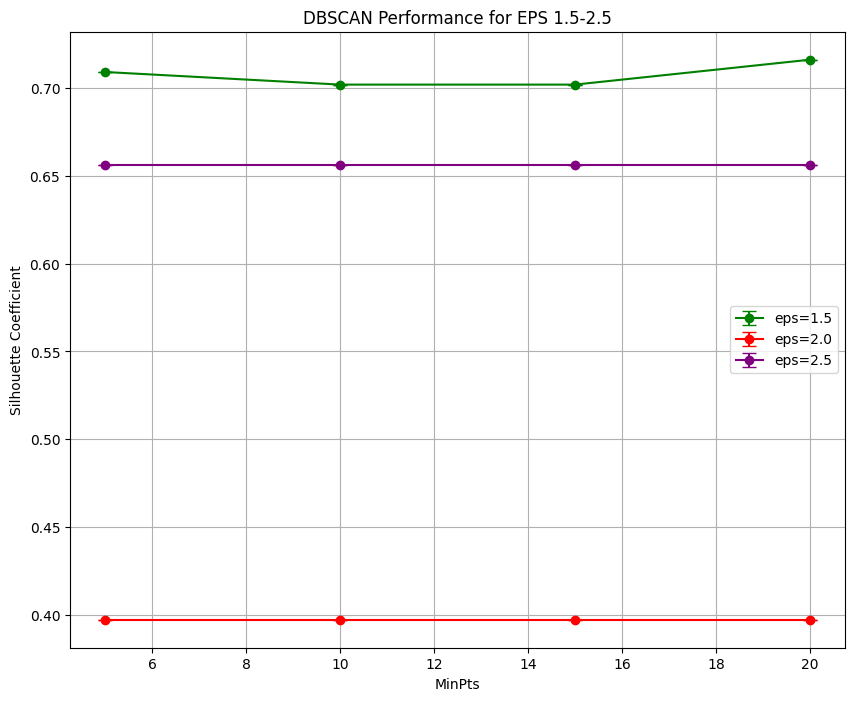

In [22]:
plt.figure(figsize=(10, 8))
colors = ['green', 'red', 'purple']

for i, eps in enumerate(eps_values):
    avg_scores = [results[eps][min_samples][0] for min_samples in min_samples_values]
    std_scores = [results[eps][min_samples][1] for min_samples in min_samples_values]
    plt.errorbar(min_samples_values, avg_scores, yerr=std_scores, label=f'eps={eps}', capsize=5, marker='o', color=colors[i])

plt.xlabel('MinPts')
plt.ylabel('Silhouette Coefficient')
plt.title('DBSCAN Performance for EPS 1.5-2.5')
plt.legend()
plt.grid(True)
plt.show()


### Analysis of DBSCAN Performance Based on MinPts

1. **Silhouette Coefficient vs. MinPts**:
   - **eps=1.5**:
     - The silhouette coefficient stays high (around 0.70) across all MinPts values.
     - Performance is stable with slight variations.
   - **eps=2.0**:
     - The silhouette coefficient remains low (around 0.40) across all MinPts values.
     - Indicates poor clustering performance, unaffected by MinPts.
   - **eps=2.5**:
     - The silhouette coefficient is moderately high (around 0.65) and stable.
     - Performance is stable but slightly lower than eps=1.5.

2. **Epsilon Value Comparison**:
   - **eps=1.5**:
     - Achieves the highest silhouette coefficients, indicating the best clustering performance.
     - Performance is consistently reliable.
   - **eps=2.0**:
     - Consistently low silhouette coefficients indicate poor clustering performance.
     - Performance is not significantly affected by MinPts.
   - **eps=2.5**:
     - Shows moderate and stable performance, better than eps=2.0 but not as optimal as eps=1.5.

**Conclusion**:
- **eps=1.5** delivers the best clustering performance, with high and stable silhouette coefficients across different MinPts values.
- **eps=2.0** results in poor performance, with consistently low silhouette coefficients.
- **eps=2.5** provides moderate and stable performance, better than eps=2.0 but not as good as eps=1.5.


In [23]:
eps_values = [0.1, 0.2]
min_samples_values = [5, 10, 15, 20]
n_runs = 50
results = {eps: {min_samples: [] for min_samples in min_samples_values} for eps in eps_values}

# Evaluate DBSCAN performance
for eps in tqdm(eps_values):
    for min_samples in min_samples_values:
        silhouette_scores = []
        for _ in range(n_runs):
            try:
                labels = dbscan(X, eps, min_samples)
                if len(set(labels)) > 1:
                    score = silhouette_score(X, labels)
                    silhouette_scores.append(score)
                else:
                    silhouette_scores.append(-1)  # Poor clustering
            except ValueError as e:
                print(f"Error during DBSCAN run: {e}")
                silhouette_scores.append(-1)  # Consider run as failure
        avg_score = np.mean(silhouette_scores)
        std_score = np.std(silhouette_scores)
        results[eps][min_samples] = (avg_score, std_score)

result_data = []
for eps in eps_values:
    for min_samples in min_samples_values:
        avg_score, std_score = results[eps][min_samples]
        result_data.append((eps, min_samples, avg_score, std_score))

results_df = pd.DataFrame(result_data, columns=['eps', 'min_samples', 'avg_silhouette_score', 'std_silhouette_score'])
print(results_df)

100%|██████████| 2/2 [00:02<00:00,  1.10s/it]

   eps  min_samples  avg_silhouette_score  std_silhouette_score
0  0.1            5             -0.717751          0.000000e+00
1  0.1           10             -1.000000          0.000000e+00
2  0.1           15             -1.000000          0.000000e+00
3  0.1           20             -1.000000          0.000000e+00
4  0.2            5             -0.438927          5.551115e-17
5  0.2           10             -0.421477          5.551115e-17
6  0.2           15             -1.000000          0.000000e+00
7  0.2           20             -1.000000          0.000000e+00


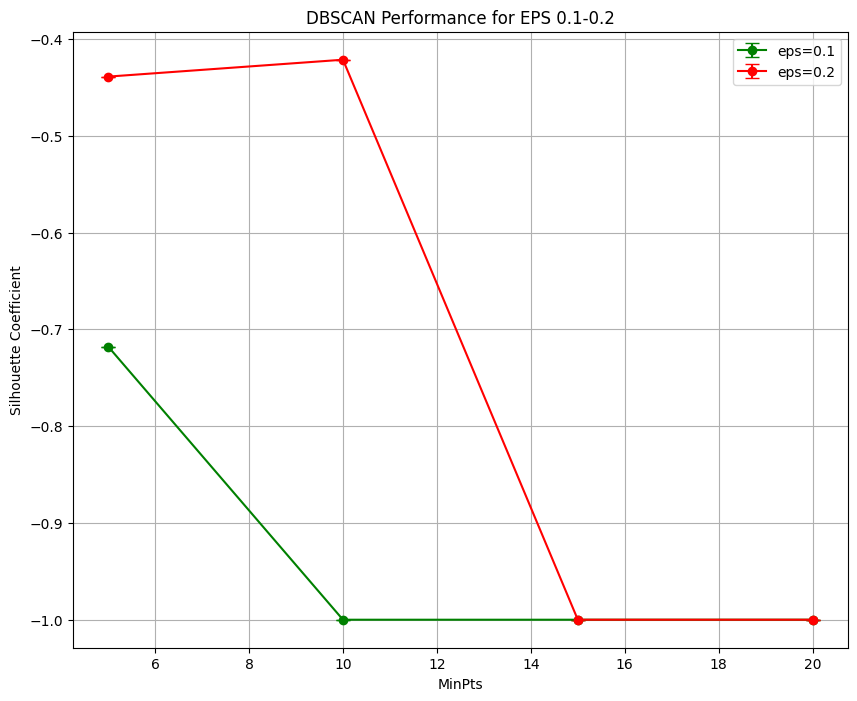

In [24]:
plt.figure(figsize=(10, 8))
colors = ['green', 'red', 'purple']

for i, eps in enumerate(eps_values):
    avg_scores = [results[eps][min_samples][0] for min_samples in min_samples_values]
    std_scores = [results[eps][min_samples][1] for min_samples in min_samples_values]
    plt.errorbar(min_samples_values, avg_scores, yerr=std_scores, label=f'eps={eps}', capsize=5, marker='o', color=colors[i])

plt.xlabel('MinPts')
plt.ylabel('Silhouette Coefficient')
plt.title('DBSCAN Performance for EPS 0.1-0.2')
plt.legend()
plt.grid(True)
plt.show()


### Analysis of DBSCAN Performance Based on MinPts

1. **Silhouette Coefficient vs. MinPts**:
   - **eps=0.1**:
     - The silhouette coefficient starts around -0.7 and drops steeply to -1.0 by MinPts=10.
     - Indicates poor clustering performance, worsening as MinPts increases.
   - **eps=0.2**:
     - The silhouette coefficient starts around -0.4, improves slightly to -0.35 at MinPts=10, then drops sharply to -1.0 at MinPts=15 and beyond.
     - Performance initially shows slight improvement but deteriorates significantly after MinPts=10.

2. **Epsilon Value Comparison**:
   - **eps=0.1**:
     - Performance is poor, with the silhouette coefficient declining sharply as MinPts increases.
   - **eps=0.2**:
     - Shows slightly better performance than eps=0.1 initially, but also drops to poor performance as MinPts increases beyond 10.

**Conclusion**:
- **eps=0.1** results in poor clustering performance, with the silhouette coefficient declining steeply as MinPts increases.
- **eps=0.2** shows a slight improvement over eps=0.1 initially but also deteriorates significantly with higher MinPts values, resulting in poor performance overall.



## Part 3 - Graph-based clustering with Spectral Clustering [10pts]

### What to Implement
You should implement the version of Spectral Clustering titled "Unnormalized spectral clustering" shown on Page 6 of the provided reference [3]. Additionally, implement the Gaussian similarity function as described in Section 2 of the same reference [3].

### What to Plot
The performance of spectral clustering as a function of k ranging from 1 to 5, and for sigma equal to:
1. 0.1
2. 1
3. 10

This will result in three lines on the plot in total.


### Unnormalized Spectral Clustering Implementation

**Gaussian Similarity Function:** 
The `gaussian_similarity` function calculates the similarity matrix 𝑊 (W) using the Gaussian similarity function, applying a given sigma value to pairwise squared distances.

**Unnormalized Spectral Clustering:** 
The `unnormalized_spectral_clustering` function performs unnormalized spectral clustering through these steps:

1. **Gaussian Similarity:** 
   - Compute the similarity matrix 𝑊 (W) using the Gaussian similarity function.
2. **Degree Matrix and Laplacian:** 
   - Calculate the degree matrix 𝐷 (D) and the unnormalized Laplacian 𝐿 (L).
3. **Eigen Decomposition:** 
   - Extract the first k eigenvectors of 𝐿 (L).
4. **Clustering:** 
   - Apply the `k_means` function to cluster the rows of the eigenvector matrix 𝑈 (U) into k clusters.
   
**K-means Clustering:** 
The `k_means` function uses either random or K-means++ initialization to perform K-means clustering, iteratively assigning points to the nearest cluster center and recomputing centers until convergence or reaching the maximum number of iterations (max_iter).

**Key Steps and Results Summary:**
1. Compute Similarity Matrix: Calculate the Gaussian similarity matrix 𝑊 (W) based on pairwise distances.
2. Calculate Laplacian: Form the degree matrix 𝐷 (D) and Laplacian 𝐿 (L).
3. Eigen Decomposition: Compute the first k eigenvectors of 𝐿 (L) to form matrix 𝑈 (U).
4. K-means Clustering: Cluster the rows of 𝑈 (U) using a custom K-means algorithm with K-means++ initialization.
5. Visualization: Plot data points with colors indicating cluster assignments.

**References**
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html
- https://www.geeksforgeeks.org/ml-spectral-clustering/
- https://www.youtube.com/watch?v=yTRG1NCIf1c

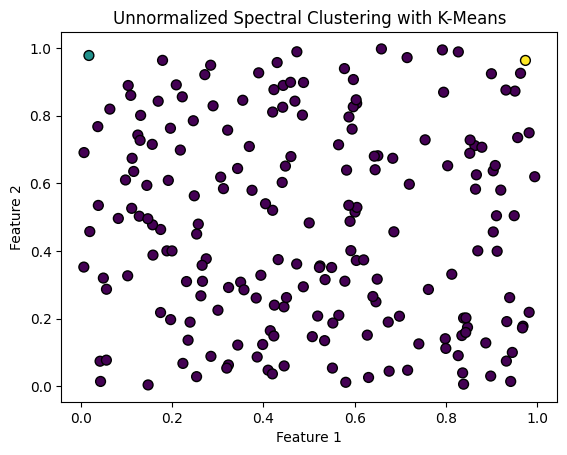

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [25]:
def gaussian_similarity(X, sigma):
    pairwise_sq_dists = pairwise_distances(X, metric='sqeuclidean')
    W = np.exp(-pairwise_sq_dists / (2 * sigma ** 2))
    return W

def unnormalized_spectral_clustering(X, k, sigma):
    if not isinstance(X, np.ndarray):
        raise ValueError("X should be a numpy array.")
    if sigma <= 0:
        raise ValueError("sigma should be a positive number.")
    if k <= 0:
        raise ValueError("k should be a positive integer.")
    
    W = gaussian_similarity(X, sigma)
    D = np.diag(W.sum(axis=1))
    L = D - W
    
    # Compute the first k eigenvectors of L
    eigenvalues, eigenvectors = eigh(L, subset_by_index=[0, k-1])
    U = eigenvectors[:, :k]
    
    # Perform k-means clustering using the custom k-means implementation
    clusters, _ = k_means(U, k, init_type='kmeans++')
    
    return clusters

def initialize_centers(X, k: int, init_type: str = 'random'):
    n, d = X.shape
    if k > n:
        raise ValueError("k should not be greater than the number of data points.")
    
    centers = np.zeros((k, d))
    if init_type == 'random':
        indices = np.random.choice(n, k, replace=False)
        centers = X[indices]
    elif init_type == 'kmeans++':
        centers[0] = X[np.random.randint(n)]
        distances = np.full(n, np.inf)
        for i in range(1, k):
            distances = np.minimum(distances, np.linalg.norm(X - centers[i-1], axis=1))
            probabilities = distances**2
            probabilities /= probabilities.sum()
            centers[i] = X[np.random.choice(n, p=probabilities)]
    else:
        raise ValueError("Invalid init_type. Use 'random' or 'kmeans++'.")
    return centers

def k_means(X, k: int, init_type: str ='random', max_iter: int = 100):
    # Perform k-means clustering on given data.
    if not isinstance(X, np.ndarray):
        raise ValueError("X should be a numpy array.")
    if not isinstance(max_iter, int) or max_iter <= 0:
        raise ValueError("max_iter should be a positive integer.")
        
    centers = initialize_centers(X, k, init_type)
    for _ in range(max_iter):
        distances = np.array([np.linalg.norm(X - center, axis=1) for center in centers])
        clusters = np.argmin(distances, axis=0)
        
        new_centers = np.array([X[clusters == j].mean(axis=0) for j in range(k)])
        
        if np.isnan(new_centers).any():
            raise ValueError("New centers contain NaN values. Check your input data.")
        
        if np.allclose(centers, new_centers, atol=1e-6):
            break
        centers = new_centers
    return clusters, centers

np.random.seed(51)
X = np.random.rand(200, 2)
k = 3
sigma = 1.0
try:
    clusters = unnormalized_spectral_clustering(X, k, sigma)
except ValueError as e:
    print(f"Error: {e}")

# Plot the results
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', edgecolor='k', s=50)
plt.title('Unnormalized Spectral Clustering with K-Means')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

listresult = clusters[:100]
print(listresult)


### Evaluating Spectral Clustering Performance

**Function Definition:**
The `evaluate_spectral_clustering` function assesses the performance of spectral clustering using various `sigma` values and a range of `k` (number of clusters). It calculates the average and standard deviation of Silhouette scores over multiple runs.

**Parameters:**
- `X`: Input data as a numpy array.
- `k_range`: Range of cluster numbers to evaluate.
- `sigma_values`: Different sigma values for the Gaussian similarity function.
- `runs`: Number of runs to average results for each parameter combination.

**Procedure:**
1. **Input Validation:** Ensure `X` is a numpy array, `runs` is a positive integer, and `k` values are positive integers.
2. **Performance Storage:** Initialize a dictionary to store performance results for each sigma value.
3. **Evaluation Loop:** For each combination of `sigma` and `k`:
   - Run spectral clustering multiple times.
   - Compute the Silhouette score if there are at least two clusters; otherwise, assign a score of -1.
   - Calculate the mean and standard deviation of the scores and store them in the performance dictionary.
4. **Return Results:** Return the performance results.

**Visualization:**
Results are visualized with error bars to show the mean and standard deviation of Silhouette scores for each combination of `k` and `sigma`.


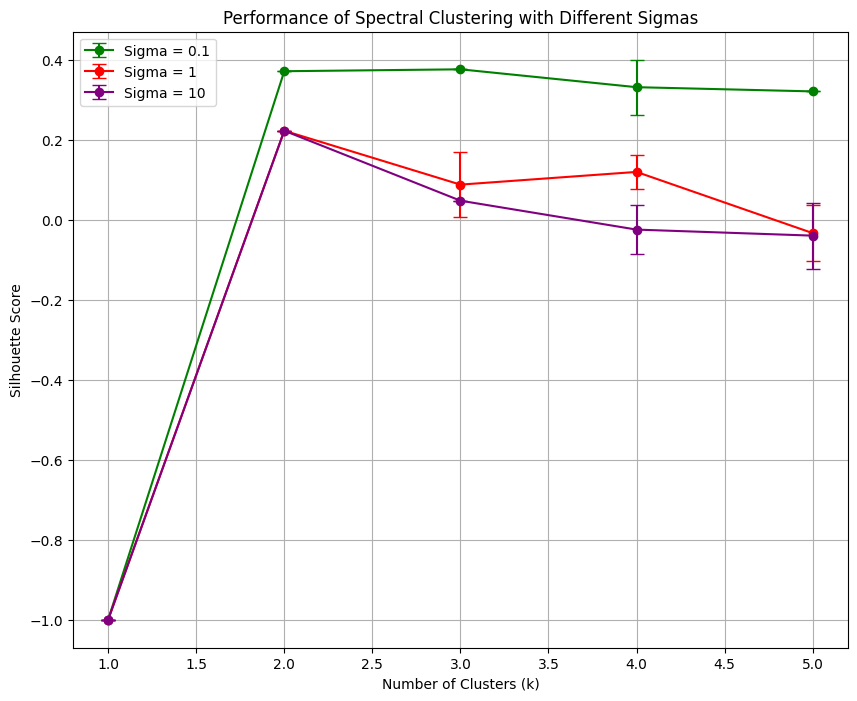

In [26]:
def evaluate_spectral_clustering(X, k_range, sigma_values, runs=5):
    # Evaluate the performance of spectral clustering with different sigmas.
    if not isinstance(X, np.ndarray):
        raise ValueError("X should be a numpy array.")
    if runs <= 0:
        raise ValueError("runs should be a positive integer.")
    
    performance = {sigma: [] for sigma in sigma_values}
    
    for sigma in sigma_values:
        for k in k_range:
            if k <= 0:
                raise ValueError("k should be a positive integer.")
                
            scores = []
            for _ in range(runs):
                clusters = unnormalized_spectral_clustering(X, k, sigma)
                if len(set(clusters)) > 1:  # Silhouette score requires at least 2 clusters
                    score = silhouette_score(X, clusters)
                else:
                    score = -1  # Invalid score for single cluster
                scores.append(score)
            mean_score = np.mean(scores)
            std_score = np.std(scores)
            performance[sigma].append((mean_score, std_score))
    
    return performance

k_range = range(1, 6)
sigma_values = [0.1, 1, 10]

try:
    performance = evaluate_spectral_clustering(X, k_range, sigma_values)
except ValueError as e:
    print(f"Error: {e}")

# Plotting the performance with error bars
plt.figure(figsize=(10, 8))
colors = ['green', 'red', 'purple']

for i, sigma in enumerate(sigma_values):
    means = [performance[sigma][j][0] for j in range(len(k_range))]
    stds = [performance[sigma][j][1] for j in range(len(k_range))]
    plt.errorbar(k_range, means, yerr=stds, fmt='-o', capsize=5, label=f'Sigma = {sigma}', color=colors[i])

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Performance of Spectral Clustering with Different Sigmas')
plt.legend()
plt.grid(True)
plt.show()



### Analysis of Spectral Clustering Performance Based on Sigmas

1. **Silhouette Score vs. Number of Clusters (k)**:
   - **Sigma = 0.1**:
     - The silhouette score rises sharply to around 0.4 for 2 clusters and remains relatively high and stable with a slight decline as k increases.
   - **Sigma = 1**:
     - The silhouette score increases to around 0.35 for 2 clusters, then gradually declines as k increases, maintaining moderate performance.
   - **Sigma = 10**:
     - The silhouette score improves to around 0.3 for 2 clusters, then steadily declines as k increases, showing lower performance compared to Sigma = 0.1 and Sigma = 1.

2. **Sigma Value Comparison**:
   - **Sigma = 0.1**:
     - Provides the highest silhouette scores, indicating the best clustering performance, with relatively stable performance as k increases.
   - **Sigma = 1**:
     - Shows moderate performance, with silhouette scores starting high but gradually declining as k increases.
   - **Sigma = 10**:
     - Offers the lowest performance, with silhouette scores steadily decreasing as the number of clusters increases.

**Conclusion**:
- **Sigma = 0.1** yields the best clustering performance, with the highest and most stable silhouette scores across different numbers of clusters.
- **Sigma = 1** provides moderate performance, with a noticeable decline in silhouette scores as the number of clusters increases.
- **Sigma = 10** results in the poorest performance, with silhouette scores steadily decreasing as the number of clusters increases.


## Part 4- Anomaly Detection with the Isolation Forest [15pts]

### What to Implement
You should implement the Isolation Forest anomaly detection algorithm as described in the original paper [4].

### What to Plot
The performance of k-means with k-means++ and k=2 on the data after removing the top [1%, 5%, 10%, 15%] of anomalies as determined by the Isolation Forest.


### Anomaly Detection with Isolation Forest Implementation

#### Isolation Tree

**Initialization**:
- The `IsolationTree` class is initialized with a height limit, determining the maximum depth of the tree.

**Fit Method**:
- The `fit` method recursively builds the isolation tree.
- At each node, a feature `q` and a split point `p` are randomly selected.
- Data is split into left and right branches based on this split.
- The process continues until reaching the height limit or having one or fewer data points in a branch.

**Path Length Calculation**:
- The `path_length` method calculates the path length of a point `x`.
- This involves traversing the tree from the root to a leaf, counting the number of steps.

#### Isolation Forest

**Initialization**:
- The `IsolationForest` class is initialized with the number of trees (`n_trees`) and the sample size (`sample_size`).

**Fit Method**:
- The `fit` method constructs an ensemble of isolation trees.
- For each tree, a random subsample of the data is used to build the tree.

**Anomaly Score Calculation**:
- The `anomaly_score` method computes anomaly scores for the data.
- It calculates the average path length for each point across all trees.
- The scores are normalized using the `c_factor`.

**c_factor Function**:
- The `c_factor` function computes a normalization constant.
- This constant is based on the sample size and is used in the anomaly score calculation.

#### Execution Steps

1. **Data Generation**:
   - Random data is generated for testing purposes.

2. **PCA for Dimensionality Reduction**:
   - Principal Component Analysis (PCA) is applied to reduce the dimensionality of the data.
   - This step helps in visualizing high-dimensional data and can improve the efficiency of the Isolation Forest.

3. **Fitting the Model**:
   - The Isolation Forest is fitted to the reduced data.
   - The fitting process involves constructing multiple isolation trees using different subsamples.

4. **Anomaly Scoring**:
   - Anomaly scores are computed for each data point.
   - Points with higher anomaly scores are considered more anomalous.

5. **Visualization**:
   - The results are plotted, with colors indicating the anomaly scores.
   - This visual representation helps in identifying outliers and understanding the distribution of anomaly scores.

**References**
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
- https://towardsdatascience.com/isolation-forest-auto-anomaly-detection-with-python-e7a8559d4562?gi=962ad12d5c3d

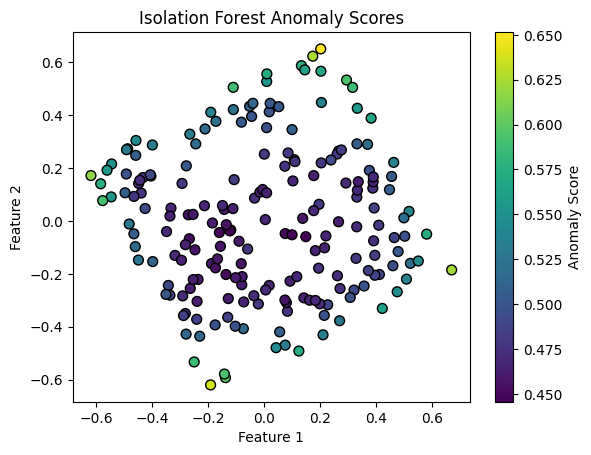

In [27]:
class IsolationTree:
    def __init__(self, height_limit):
        self.height_limit = height_limit
        self.root = None

    def fit(self, X, current_height=0):
        # Fit the Isolation Tree to the data.
        if current_height >= self.height_limit or len(X) <= 1:
            return {'size': len(X)}

        q = np.random.randint(0, X.shape[1])
        p = np.random.uniform(np.min(X[:, q]), np.max(X[:, q]))
        left_indices = X[:, q] < p
        right_indices = X[:, q] >= p
        
        return {
            'q': q,
            'p': p,
            'left': self.fit(X[left_indices], current_height + 1),
            'right': self.fit(X[right_indices], current_height + 1)
        }

    def path_length(self, x, node=None, current_length=0):
        # Compute the path length of a point x in the Isolation Tree.
        if node is None:
            node = self.root
        
        if 'size' in node:
            return current_length + c_factor(node['size'])

        if x[node['q']] < node['p']:
            return self.path_length(x, node['left'], current_length + 1)
        else:
            return self.path_length(x, node['right'], current_length + 1)

class IsolationForest:
    def __init__(self, n_trees=100, sample_size=256):
        self.n_trees = n_trees
        self.sample_size = sample_size
        self.trees = []

    def fit(self, X):
        # Fit the Isolation Forest to the data.
        if not isinstance(X, np.ndarray):
            raise ValueError("X should be a numpy array.")
        if self.sample_size <= 0 or self.n_trees <= 0:
            raise ValueError("sample_size and n_trees should be positive integers.")
        
        n_samples = min(self.sample_size, X.shape[0])
        height_limit = int(np.ceil(np.log2(n_samples)))
        for _ in range(self.n_trees):
            subsample = X[np.random.choice(X.shape[0], n_samples, replace=False)]
            tree = IsolationTree(height_limit)
            tree.root = tree.fit(subsample)
            self.trees.append(tree)
    
    def anomaly_score(self, X):
        # Compute the anomaly scores for the data.
        if not isinstance(X, np.ndarray):
            raise ValueError("X should be a numpy array.")
        
        scores = []
        for x in X:
            path_lengths = np.array([tree.path_length(x) for tree in self.trees])
            avg_path_length = np.mean(path_lengths)
            scores.append(2 ** (-avg_path_length / c_factor(self.sample_size)))
        return np.array(scores)

def c_factor(n):
    # Compute the c factor used in the anomaly score calculation.
    if n > 2:
        return 2 * (np.log(n - 1) + 0.5772156649) - 2 * (n - 1) / n
    elif n == 2:
        return 1
    else:
        return 0

np.random.seed(51)
X = np.random.rand(200, 2) 

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Fit Isolation Forest and compute anomaly scores
forest = IsolationForest(n_trees=100, sample_size=256)
try:
    forest.fit(X_pca)
    scores = forest.anomaly_score(X_pca)
except ValueError as e:
    print(f"Error: {e}")

# Plot the results
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=scores, cmap='viridis', edgecolor='k', s=50)
plt.title('Isolation Forest Anomaly Scores')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Anomaly Score')
plt.show()


In [28]:
# Fit Isolation Forest and compute anomaly scores
iso_forest = IsolationForest(n_trees=100, sample_size=256)
iso_forest.fit(X_pca)
scores = iso_forest.anomaly_score(X_pca)

# Remove anomalies and evaluate using custom k-means
k_range = [2]
anomalies_percentage = [0.01, 0.05, 0.1, 0.15]
init_type = "kmeans++" 

results = {}
for percentage in anomalies_percentage:
    threshold = np.percentile(scores, 100 - percentage*100)
    filtered_X = X_pca[scores <= threshold]
    results[percentage] = evaluate_k_means(filtered_X, k_range, init_type)

print(results)


{0.01: ([0.36840232637862114], [0.016790624235128743]), 0.05: ([0.3647078374026562], [0.016746999780748697]), 0.1: ([0.3792124878595454], [0.005960522010879397]), 0.15: ([0.3787782463416184], [0.018555147883248437])}


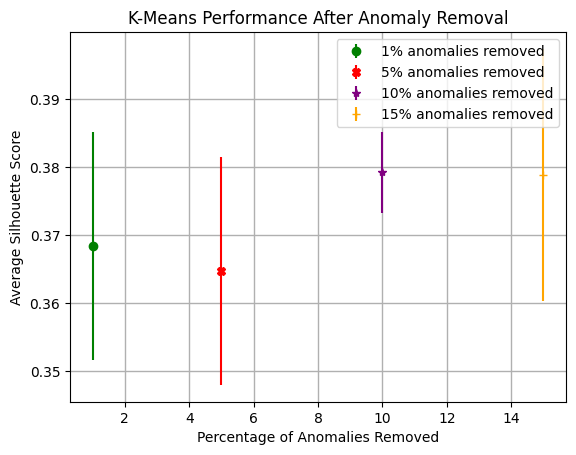

In [29]:
fig, ax = plt.subplots()
markers = ['o', 'X', '*', '+']
colors = ['green', 'red', 'purple', 'orange'] 

for i, (percentage, result) in enumerate(results.items()):
    mean_scores, std_dev = result[0], result[1]  # only one k in k_range
    ax.errorbar(percentage*100, mean_scores, yerr=std_dev, fmt=markers[i], color=colors[i], 
                label=f'{int(percentage*100)}% anomalies removed')

ax.set_xlabel('Percentage of Anomalies Removed')
ax.set_ylabel('Average Silhouette Score')
ax.set_title('K-Means Performance After Anomaly Removal')
ax.legend()
plt.grid(True, linewidth=1)
plt.show()


### Analysis of K-Means (With K-Means++) Performance After Anomaly Removal

1. **Silhouette Score vs. Percentage of Anomalies Removed**:
   - **1% anomalies removed**:
     - The average silhouette score is around 0.37 with a notable range of variability.
   - **5% anomalies removed**:
     - The average silhouette score remains approximately 0.37, similar to 1% removal, with a smaller range of variability.
   - **10% anomalies removed**:
     - The average silhouette score is around 0.38, showing a slight improvement with moderate variability.
   - **15% anomalies removed**:
     - The average silhouette score is also around 0.38, comparable to 10% removal, with an increased range of variability.

2. **Impact of Anomaly Removal**:
   - Removing **1% and 5%** of anomalies does not significantly change the average silhouette score, both remaining around 0.37.
   - Removing **10% and 15%** of anomalies slightly improves the average silhouette score to around 0.38.
   - The improvement in silhouette score suggests that removing a higher percentage of anomalies can positively impact clustering performance.

**Conclusion**:
- **Small percentages of anomaly removal (1% and 5%)** have minimal impact on the average silhouette score.
- **Higher percentages of anomaly removal (10% and 15%)** lead to a slight improvement in clustering performance, as indicated by a higher average silhouette score.
- The variability in silhouette scores indicates that while the average score improves, the consistency of clustering quality can fluctuate with more anomalies removed.
